# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete GFE-constrained SSM.

In [563]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [564]:
using LinearAlgebra
using ForneyLab
using Plots
using Random
using ForwardDiff: hessian
# using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")

Random.seed!(1234)
# Random.seed!(42)
# Random.seed!(123) # Does not learn all key entries
# Random.seed!(678) # Does not learn all key entries
;

# Algorithm for $t=1$

In [565]:
fg_t1 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
DiscreteObservation(x[1], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_1),
                    n_factors=8)
# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
DiscreteObservation(x[2], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_2),
                    n_factors=8)
# Algorithm
q_t1 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t1 = messagePassingAlgorithm(q_t1, id=:t1, free_energy=true)
code_t1 = algorithmSourceCode(algo_t1, free_energy=true)
eval(Meta.parse(code_t1))
;

In [566]:
function averageEnergyDecomp(::Type{DiscreteObservation},
    marg_out::Distribution{Univariate},
    marg_A::Distribution{MatrixVariate},
    marg_c::Distribution{Multivariate})

    s = unsafeMean(marg_out)
    A = unsafeMean(marg_A)
    log_c = unsafeLogMean(marg_c)

    risk = (A*s)'*(safelog.(A*s) - log_c)
    amb = -s'*diag(A'*safelog.(A)) 

    return (risk, amb)
end


averageEnergyDecomp (generic function with 1 method)

In [567]:
function freeEnergyDecompt1(data::Dict, marginals::Dict)
    F = 0.0
    risk = 0.0
    amb = 0.0
    nov = 0.0
    
    F += averageEnergy(Categorical, marginals[:x_0], Distribution(Multivariate, PointMass, m=data[:D_t_min]))
    nov += averageEnergy(Dirichlet, marginals[:A], Distribution(MatrixVariate, PointMass, m=data[:A_s]))
    (risk_1, amb_1) = averageEnergyDecomp(DiscreteObservation, marginals[:x_1], marginals[:A], Distribution(Multivariate, PointMass, m=data[:C]))
    (risk_2, amb_2) = averageEnergyDecomp(DiscreteObservation, marginals[:x_2], marginals[:A], Distribution(Multivariate, PointMass, m=data[:C]))
    risk += risk_1 + risk_2
    amb += amb_1 + amb_2
    F += averageEnergy(Transition, marginals[:x_1_x_0], Distribution(MatrixVariate, PointMass, m=data[:u][1]))
    F += averageEnergy(Transition, marginals[:x_2_x_1], Distribution(MatrixVariate, PointMass, m=data[:u][2]))
    
    nov -= differentialEntropy(marginals[:A])
    F -= -1*differentialEntropy(marginals[:x_1])
    F -= differentialEntropy(marginals[:x_1_x_0])
    F -= differentialEntropy(marginals[:x_2_x_1])

    return (risk/log(2), amb/log(2), nov/log(2))
end

freeEnergyDecompt1 (generic function with 1 method)

# Algorithm for $t=2$

In [568]:
fg_t2 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
@RV y[1] ~ Transition(x[1], A)
placeholder(y[1], :y, index=1, dims=(16,))

# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
DiscreteObservation(x[2], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_2),
                    n_factors=8)
# Algorithm
q_t2 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t2 = messagePassingAlgorithm(q_t2, id=:t2, free_energy=true)
code_t2 = algorithmSourceCode(algo_t2, free_energy=true)
eval(Meta.parse(code_t2))
;

# Algorithm for $t=3$ (Learning)

In [569]:
fg_t3 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
@RV y[1] ~ Transition(x[1], A)
placeholder(y[1], :y, index=1, dims=(16,))

# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
@RV y[2] ~ Transition(x[2], A)
placeholder(y[2], :y, index=2, dims=(16,))

# Algorithm
q_t3 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t3 = messagePassingAlgorithm(q_t3, id=:t3, free_energy=true)
code_t3 = algorithmSourceCode(algo_t3, free_energy=true)
eval(Meta.parse(code_t3))
;

## Action-Perception Loop

In [570]:
α = 0.9; c = 2.0 # Reward probability and utility
S = 50 # Number of simulations

include("helpers.jl")
include("environment.jl")
include("agent_2.jl")

(A, B, C, D) = constructABCD(α, c)
A_0 = constructAPrior() # Construct prior statistics for A

(reset, execute, observe) = initializeWorld(A, B, C, D) # Let there be a world
(infer, act) = initializeAgent(A_0, B, C, D) # Let there be a constrained agent

# Step through the experimental protocol
As = Vector{Matrix}(undef, S) # Posterior statistics for A
Gts = [[Matrix(undef, 4, 4), Vector(undef, 4), undef] for s=1:S] # Free energy values
riskts = [[Matrix(undef, 4, 4), Vector(undef, 4), undef] for s=1:S] # Free energy values
ambts = [[Matrix(undef, 4, 4), Vector(undef, 4), undef] for s=1:S] # Free energy values
novts = [[Matrix(undef, 4, 4), Vector(undef, 4), undef] for s=1:S] # Free energy values
ats = [Vector{Int64}(undef, 2) for s=1:S] # Actions
polts = [[Vector{Int64}(undef, 2), undef] for s=1:S] # Policies
gamts = [[Vector{Float64}(undef, 16), Vector{Float64}(undef, 16)] for s=1:S] # Policies
ots = [Vector{Vector}(undef, 2) for s=1:S] # Observations (1-of-K)
rs  = Vector{Int64}(undef, S) # Hidden reward positions
for s = 1:S
    rs[s] = reset() # Reset world
    for t = 1:2
        if t == 1
            (Gts[s][t], riskts[s][t], ambts[s][t], novts[s][t]) = infer(t, ats[s], ots[s])
        elseif t == 2
            Gts[s][t] = infer(t, ats[s], ots[s])
        end
        (ats[s][t], polts[s][t]) = act(Gts[s][t])
                    execute(ats[s][t])
        ots[s][t] = observe()
    end
    (Gts[s][3], As[s]) = infer(3, ats[s], ots[s]) # Learn
end
;

# Results

In [571]:
sum([ats[s].==rs[s] for s=1:S]) # Correct vists per timepoint

2-element Vector{Int64}:
  0
 96

In [572]:
plotObservationStatistics(As[S], A_0)

4×8 SparseMatrixCSC{Float64, Int64} with 12 stored entries:
 0.5  0.5    ⋅    ⋅    ⋅     ⋅   43.0   4.0
 0.5  0.5    ⋅    ⋅    ⋅     ⋅     ⋅   53.0
  ⋅    ⋅   41.0   ⋅   1.0  46.0    ⋅     ⋅ 
  ⋅    ⋅     ⋅   5.0   ⋅    5.0    ⋅     ⋅ 

In [573]:
include("visualizations.jl")

s=4
plotObservationStatistics(As[s], As[s-1])

4×8 SparseMatrixCSC{Float64, Int64} with 3 stored entries:
  ⋅   0.5   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.5   ⋅    ⋅    ⋅    ⋅    ⋅   1.0
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 

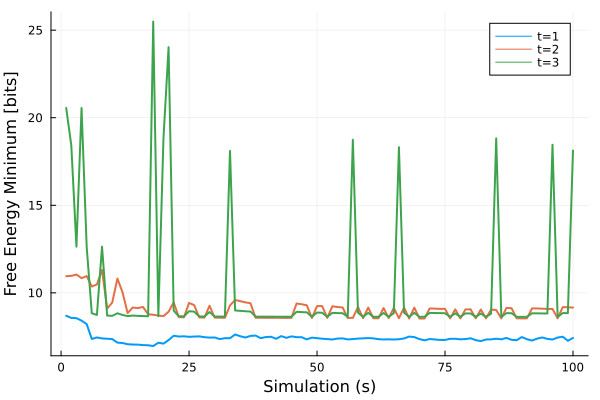

In [574]:
plotFreeEnergyMinimum(Gts)

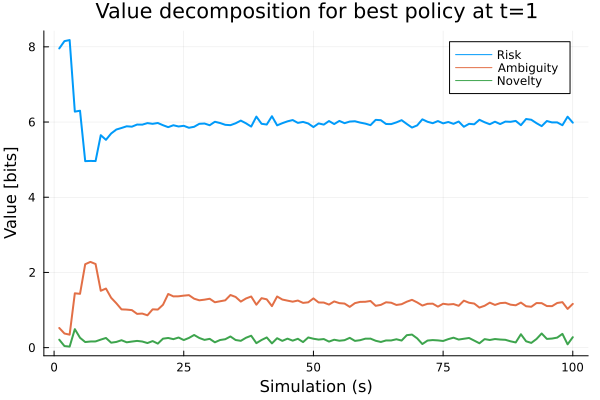

In [575]:
plotDecomposition(polts, riskts, ambts, novts)

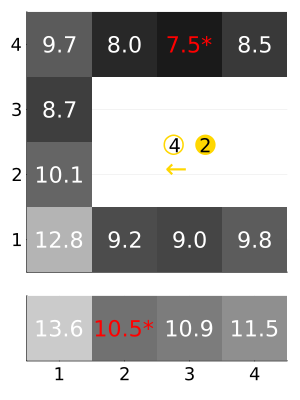

In [576]:
s = 7
plotFreeEnergies(Gts[s], ats[s], ots[s], rs[s])

In [577]:
hcat(ats, rs)

100×2 Matrix{Any}:
 [4, 1]  2
 [4, 2]  3
 [4, 2]  2
 [4, 1]  3
 [4, 3]  2
 [4, 2]  2
 [4, 2]  2
 [4, 3]  3
 [4, 2]  2
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 [4, 2]  2
 ⋮       
 [4, 2]  2
 [4, 2]  2
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 [4, 3]  3
 [4, 3]  3
 [4, 3]  3
 [4, 2]  2
 [4, 3]  3
 [4, 3]  3
 [4, 3]  3